# 01 — Load & Inspect Clean Dataset
This notebook only *uses* reusable code in `src/` to load and inspect data.


In [9]:
# Imports
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute project ROOT (works whether the notebook sits in / or /notebooks)
ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()

# (Optional) ensure we can import from src/
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.data_loader import load_config
cfg = load_config()

# ✅ Build absolute path to the processed file (robust)
processed_path = (ROOT / cfg["paths"]["processed_data_dir"] / cfg["paths"]["processed_filename"]).resolve()
print("Processed path:", processed_path)
print("Exists?", processed_path.exists())


Processed path: C:\Users\sauna\DS Projects\Financial_Analytics_LDP\data\processed\loan_default_clean.csv
Exists? True


# 02 — EDA


In [13]:
df = pd.read_csv(processed_path)
df.head()
df.shape
df.info()

# Class balance default vs non-default
df["DEFAULT"].value_counts(dropna=False).to_frame("count").assign(
    pct=lambda t: (t["count"] / t["count"].sum()).round(4)
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   employed       10000 non-null  int64  
 1   bank_balance   10000 non-null  float64
 2   annual_salary  10000 non-null  float64
 3   DEFAULT        10000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 312.6 KB


,count,pct
DEFAULT,,
0,9667,0.9667
1,333,0.0333


- Target balance: DEFAULT=1 is 333 cases (3.33%) and DEFAULT=0 is 9,667 (96.67%).
Shows a heavily imbalanced problem, dataset is heavily skewed towards non-default cases.

- Implications: Training a model directly on this dataset might predict “0” (non-default) for almost everyone and still achieve ~96% accuracy — but it would fail to detect real defaults.

In [14]:
# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
pd.DataFrame({"missing_count": missing, "missing_percent": missing_pct})

,missing_count,missing_percent
employed,0,0.0
bank_balance,0,0.0
annual_salary,0,0.0
DEFAULT,0,0.0


In [12]:
# Descriptive Stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
employed,10000.0,0.705600,0.455795,0.00,0.00,1.00,1.00,1.00
bank_balance,10000.0,10024.498524,5804.579486,0.00,5780.79,9883.62,13995.66,31851.84
annual_salary,10000.0,402203.782224,160039.674988,9263.64,256085.52,414631.74,525692.76,882650.76
DEFAULT,10000.0,0.033300,0.179428,0.00,0.00,0.00,0.00,1.00


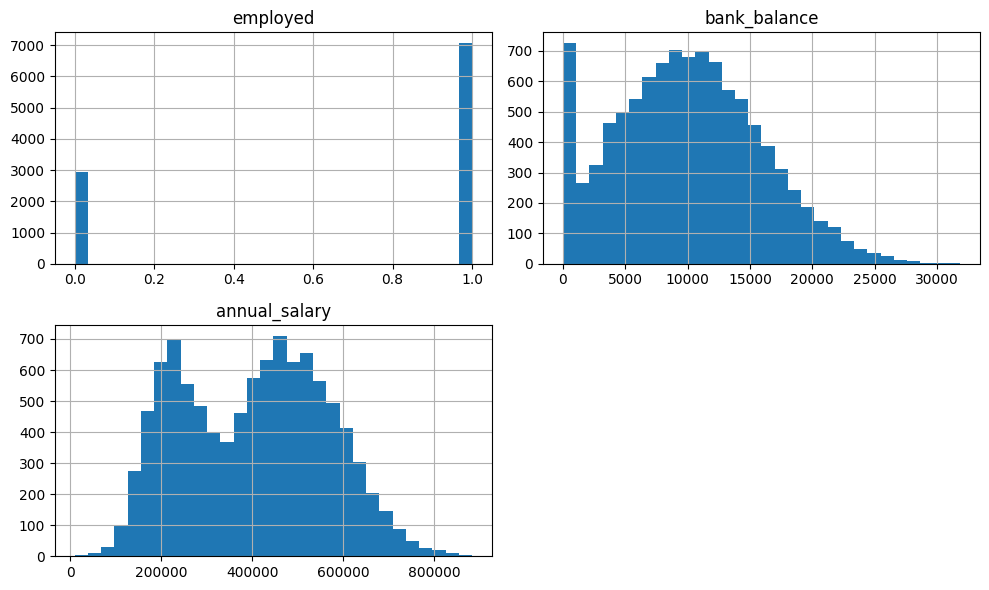

In [ ]:
# Distribution of numeric features (contnuous and discrete numeric)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("DEFAULT")
df[numeric_cols].hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()

In [ ]:
# How numeric features differ between people who defaulted vs. didn’t default
group_means = df.groupby("DEFAULT")[numeric_cols].mean().T
display(group_means)

DEFAULT,0,1
employed,0.708596,0.618619
bank_balance,9647.324961,20973.858378
annual_salary,402793.999321,385069.762162


# Interpetation

- Employed:
Non-defaulters: ~71% are employed.
Defaulters: ~62% are employed.
Slightly fewer employed people among defaulters — employment might reduce risk of default, but the difference is not huge.

- Bank Balance:
Surprisingly, defaulters have much higher average bank balances (~21k) than non-defaulters (~9.6k). This could mean higher balances don’t necessarily prevent default — maybe these are high-debt customers or have large pending obligations.

- Annual Salary:
Defaulters earn slightly less on average (~385k vs ~403k), but the difference is small. Salary alone may not be a strong predictor without other context.

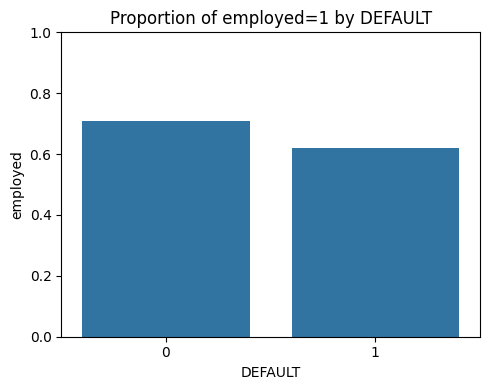

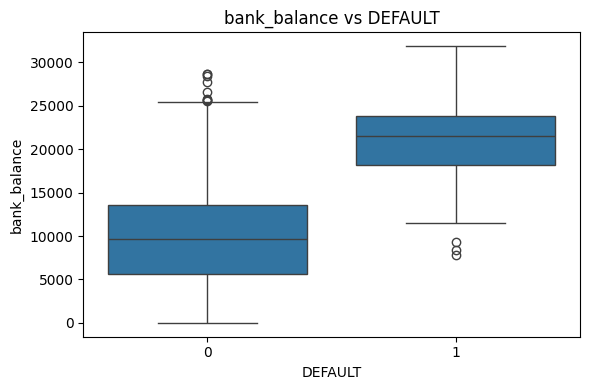

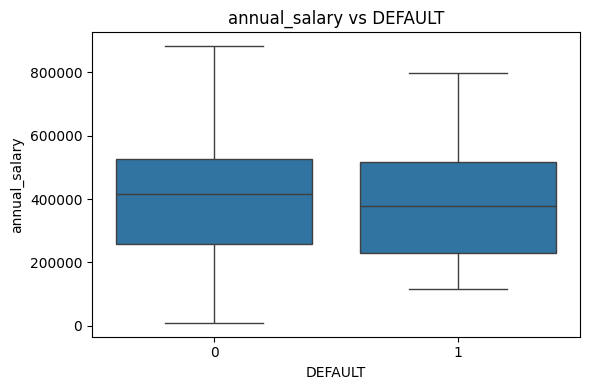

In [21]:
# Boxplots
for col in numeric_cols:
    if df[col].nunique() <= 2:  # Discrete (binary)
        plt.figure(figsize=(5, 4))
        sns.barplot(x="DEFAULT", y=col, data=df, errorbar=None)
        plt.title(f"Proportion of {col}=1 by DEFAULT")
        plt.ylim(0, 1)
    else:  # Continuous
        plt.figure(figsize=(6, 4))
        sns.boxplot(x="DEFAULT", y=col, data=df)
        plt.title(f"{col} vs DEFAULT")
    plt.tight_layout()
    plt.show()


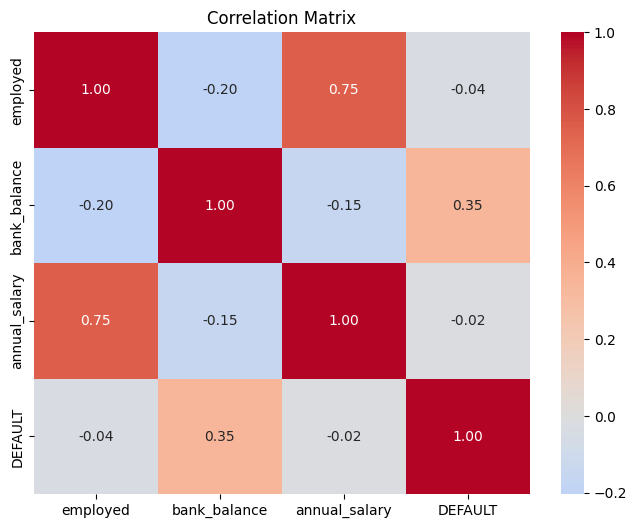

In [ ]:
# Correlation Analysis
# Heatmap Pearson correlation
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

| Variable Pair                 | Correlation | Meaning                                                                                                                                                                   |
| ----------------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **employed & annual\_salary** | **0.75**    | Strong positive correlation — employed people tend to have higher salaries. This might cause **multicollinearity** if both are used in a regression model.                |
| **bank\_balance & DEFAULT**   | **0.35**    | Weak-to-moderate positive correlation — higher bank balances are *slightly* more common in defaulted cases in your dataset. This is unusual, so it’s worth investigating. |
| **employed & bank\_balance**  | -0.20       | Weak negative — unemployed people have *slightly* higher bank balances here, which might also be dataset-specific.                                                        |
| **annual\_salary & DEFAULT**  | -0.02       | Essentially no correlation — salary alone doesn’t explain default in this dataset.                                                                                        |
| **employed & DEFAULT**        | -0.04       | Almost no correlation — employment status by itself is not strongly predictive here.                                                                                      |


# Takeaways

- Class Imbalance:

Dataset is highly imbalanced. This means a simple model predicting “no default” will already have ~97% accuracy, but that would be useless in practice. So, we will need strategies to handle imbalance (oversampling, undersampling, or algorithm-level adjustments). Accuracy itself may be misleading; so we have to use ROC-AUC + PR-AUC, do stratified splits, and set class_weight='balanced' (or an equivalent approach) when training.

- Numeric feature relationships : 

Bank balance has a weak-to-moderate correlation with default, but in an unexpected direction — worth deeper investigation. 

Annual salary and employment are strongly correlated (0.75) — potential multicollinearity risk in some models.

No single variable is strongly correlated with default → suggests loan default is driven by multiple factors interacting together, not one big obvious driver.

- Next up is Feature Engineering 

Since there are only few features to predict a model, we create ratios (e.g., bank balance / annual salary), and flags for certain thresholds (e.g., employed == 0 and bank balance < X). Then we address * Class Imbalance *

If we handle class imbalance before creating new features, we’ll just be oversampling the same limited information — which often leads to overfitting. Good features make the imbalance-handling techniques more effective, because the model gets richer, more informative examples. For e.g. a feature like bank_balance_to_salary_ratio, it may strongly distinguish between defaults and non-defaults. When we later oversample defaults, we’ll be replicating meaningful patterns instead of just duplicating raw rows

Better features first → Then balance the data